In [15]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

import custom_plotting as cp


In [ ]:
config = yaml.safe_load(open('../config.yaml'))


In [2]:
LABEL = config['general']['label']
RSEED = config['etl']['rseed']

# Load in data
df = pd.read_pickle('../dataset/discretized_dataset')

# Extract the labels
labels = np.array(df.pop(LABEL))


In [3]:
# 30% examples in test data
train, test, train_labels, test_labels = train_test_split(df,
                                         labels, 
                                         stratify = labels,
                                         test_size = 0.1, 
                                         random_state = RSEED)

# Imputation of missing values
train = train.fillna(train.mean())
test = test.fillna(test.mean())

# Features for feature importances
features = list(train.columns)

# Create the model
model = RandomForestClassifier(n_estimators=250, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

# Fit on training data
model.fit(train, train_labels)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   22.4s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=-1,
            oob_score=False, random_state=50, verbose=1, warm_start=False)

In [4]:
n_nodes = []
max_depths = []

# Stats about the trees in random forest
for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print('Average number of nodes'+ str(np.mean(n_nodes)))
print('Average maximum depth '+str(np.mean(max_depths)))


Average number of nodes27371.928
Average maximum depth 45.78


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    3.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      |

In [ ]:
# Training set predictions (to demonstrate overfitting)
train_rf_predictions = model.predict(train)
train_rf_probs = model.predict_proba(train)[:, 1]

# Testing set predictions
rf_predictions = model.predict(test)
rf_probs = model.predict_proba(test)[:, 1]


RecallBaseline: 1.0 Test: 1.0 Train: 1.0
PrecisionBaseline: 0.92 Test: 0.92 Train: 1.0
RocBaseline: 0.5 Test: 0.69 Train: 1.0


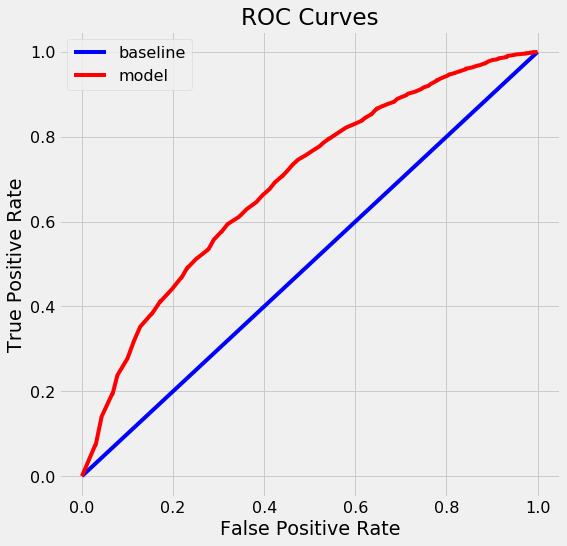

In [19]:
cp.evaluate_model(test_labels, rf_predictions, rf_probs, train_labels, train_rf_predictions, train_rf_probs)


[[   28  1130]
 [   43 13498]]


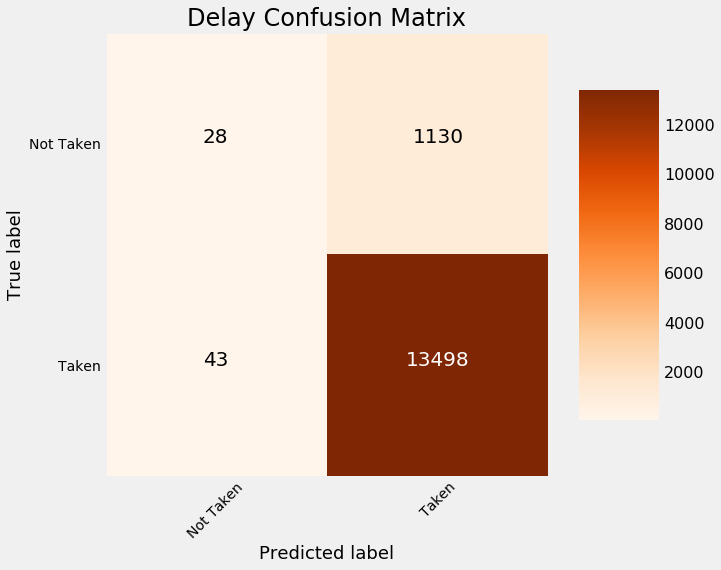

In [20]:
# Confusion matrix
cm = confusion_matrix(test_labels, rf_predictions)
plot_confusion_matrix(cm, classes = ['Not Taken', 'Taken'],
                      title = 'Delay Confusion Matrix')


In [ ]:
# Confusion matrix
cm = confusion_matrix(test_labels, (model.predict_proba(test)[:, 1] > 0.8).astype(int))
plot_confusion_matrix(cm, classes = ['Not Taken', 'Taken'],
                      title = 'Delay Confusion Matrix')


In [ ]:
# Extract feature importances
fi = pd.DataFrame({'feature': list(train.columns),
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)


fi.head(20).plot.bar(x='feature')